<a href="https://colab.research.google.com/github/Sayantan108/Denoiser-using-DnCNN/blob/main/final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collecting the dataset
We will be using the BSDS500 datatset, 
which is a collection of natural images

In [1]:
!git clone "https://github.com/BIDS/BSDS500.git"

Cloning into 'BSDS500'...
remote: Enumerating objects: 2380, done.
remote: Total 2380 (delta 0), reused 0 (delta 0), pack-reused 2380
Receiving objects: 100% (2380/2380), 155.21 MiB | 32.37 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (2268/2268), done.


# Extracting the images to current working directory

In [2]:
!cp -r BSDS500/BSDS500/data/images .

# Studying the images

In [3]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow

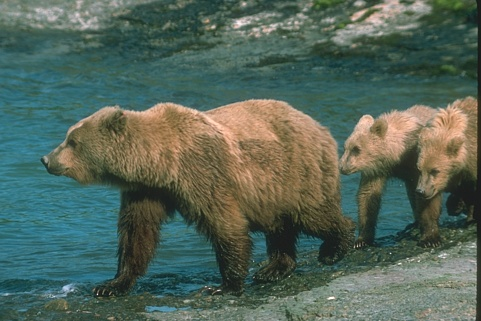

(321, 481, 3)

In [4]:
image = cv2.imread('./images/train/100075.jpg')
cv2_imshow(image)
image.shape

So, we see that the image is of 321x481 with 3 channels(RGB channels). We will be perfroming CNN. So, we are required to divide the image into patches. We will be considering patches of size 40x40. We will be considering a stride size of 40.

## Extraction of patches
We will be reading the image using cv2,followed by which, we will be
extracting its information like filename, height,width, channel length.
Then, we will be cropping(scaling the image) it as requried. Then, we can extract the patches according to our requirements and save the image for the model.

In [11]:
def extract_patches(filepath, patch_sz,crop_szs,save_dir=None):
  image=cv2.imread(filepath)
  filename=filepath.split('/')[-1].split('.')[0] #extracting imgname.jpg
  height,width,channels=image.shape
  patches=[]
  for crop_sz in crop_szs:
    crop_ht,crop_wd=int(height*crop_sz),int(width*crop_sz)
    image_scaled=cv2.resize(image,(crop_wd,crop_ht), interpolation=cv2.INTER_CUBIC)
    for i in range(0,crop_ht-patch_sz+1,patch_sz):
      for j in range(0,crop_wd-patch_sz+1,patch_sz):
        x=image_scaled[i:i+patch_sz,j:j+patch_sz]

        if save_dir is not None:
          if not os.path.exists(save_dir):
            os.mkdir(save_dir)
          patch_filepath = save_dir+'/'+filename+'_'+str(crop_ht)+'_'+str(i)+'_'+str(j)+'.jpg'
          cv2.imwrite(patch_filepath,x)

        patches.append(x)
  return patches

## Joining the patches to form the image
We create a numpy matrix, which resembles the image in height and width. Then we keep on writing every patch to its corresponding location in the image.

In [8]:
def join_patches(patches,img_shp):
  image=np.zeros(img_shp)
  patch_sz=patches.shape[1]
  p=0
  for i in range(0,image.shape[0]-patch_sz+1,patch_sz):
    for j in range(0,image.shape[1]-patch_sz+1,patch_sz):
      image[i:i+patch_sz,j:j+patch_sz]=patches[p]
      p+=1
  return np.array(image)

# Creation of data
We extract the patches of image from every image and then save it in current directory

In [12]:
def create_data(data_dir,save_dir=None):
  '''This function create data for all the images present in a directory'''
  files_list=os.listdir(data_dir)
  print('Number of files in the '+data_dir+' is : '+str(len(files_list)))
  patch_size = 40
  crop_sizes = [1, 0.8, 0.7,0.5]
  data=[]
  for file in files_list:
    if file.endswith('.jpg'):
      patches=extract_patches(data_dir+'/'+file,patch_size,crop_sizes,save_dir)
      data+=patches
  return data

In [13]:
import os
os.mkdir('./data')
os.mkdir('./data/patches')

In [14]:
create_data('./images/train','./data/patches/train')
print('Number of pactches obtained from train data : ',len(os.listdir('./data/patches/train')))

Number of files in the ./images/train is : 201
Number of pactches obtained from train data :  42800


In [15]:
create_data('./images/val','./data/patches/val')
print('Number of pactches obtained from validation data : ',len(os.listdir('./data/patches/val')))

Number of files in the ./images/val is : 101
Number of pactches obtained from validation data :  21400


## Performance Metric

We use **PSNR** to measure the quality of image obtained out of noise compression. It is an expression for the ratio between the maximum possible value of a signal and the power of distorting noise that affects its quality.

In [16]:
def PSNR(grnd_trth,image,max_val=1):
  ht,wd,channel=grnd_trth.shape
  wd=wd//40*40
  ht=ht//40*40
  mse=np.mean((grnd_trth-image)**2)
  if mse == 0:
    return 100
  return 20*np.log10(max_val/(np.sqrt(mse)))

# Model Creation

In [17]:
from tensorflow.keras.layers import Subtract,Input,Conv2D,BatchNormalization,Activation
from tensorflow.keras.models import Model

def DnCNN():
    
    input = Input(shape=(40,40,3),name='input')
    x = Conv2D(64,kernel_size= (3,3), padding='same',name='conv2d_l1')(input)
    x = Activation('relu',name='act_l1')(x)
    for i in range(17):
        x = Conv2D(64, kernel_size=(3,3), padding='same',name='conv2d_'+str(i))(x)
        x = BatchNormalization(axis=-1,name='BN_'+str(i))(x)
        x = Activation('relu',name='act_'+str(i))(x)   
    x = Conv2D(3, kernel_size=(3,3), padding='same',name='conv2d_l3')(x)
    x = Subtract(name='subtract')([input, x])   
    model = Model(input,x)
    
    return model

In [27]:
dncnn= DnCNN()

dncnn.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-03), loss=tf.keras.losses.MeanAbsoluteError())

In [19]:
dncnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 conv2d_l1 (Conv2D)             (None, 40, 40, 64)   1792        ['input[0][0]']                  
                                                                                                  
 act_l1 (Activation)            (None, 40, 40, 64)   0           ['conv2d_l1[0][0]']              
                                                                                                  
 conv2d_0 (Conv2D)              (None, 40, 40, 64)   36928       ['act_l1[0][0]']                 
                                                                                              

# Preparation of dataset

In [20]:
train_files=['data/patches/train/'+filename for filename in os.listdir('data/patches/train')]
val_files=['data/patches/val/'+filename for filename in os.listdir('data/patches/val')]

In [21]:
def _parse_function(filename):
    '''This function performs adding noise to the image given by Dataset'''
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)/255.

    noise_level=np.random.choice(NOISE_LEVELS)
    noisy_image=image+tf.random.normal(shape=(40,40,3),mean=0,stddev=noise_level/255)
    noisy_image=tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)

    return noisy_image,image

In [24]:
BATCH_SIZE=64
NOISE_LEVELS=[15,25,20] 

#Creating the Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(train_files)) 
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(np.array(val_files))
val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.batch(BATCH_SIZE)


In [25]:
import tensorflow_datasets as tfds

In [28]:
history=dncnn.fit( train_dataset,shuffle=True,epochs=30,validation_data= val_dataset)

Epoch 1/30
669/669 [==============================] - 100s 147ms/step - loss: 0.0781 - val_loss: 0.0456
Epoch 2/30
669/669 [==============================] - 96s 143ms/step - loss: 0.0751 - val_loss: 0.0467
Epoch 3/30
669/669 [==============================] - 105s 158ms/step - loss: 0.0748 - val_loss: 0.0456
Epoch 4/30
669/669 [==============================] - 96s 144ms/step - loss: 0.0616 - val_loss: 0.0430
Epoch 5/30
669/669 [==============================] - 104s 155ms/step - loss: 0.0588 - val_loss: 0.0400
Epoch 6/30
669/669 [==============================] - 95s 142ms/step - loss: 0.0583 - val_loss: 0.0379
Epoch 7/30
669/669 [==============================] - 95s 142ms/step - loss: 0.0578 - val_loss: 0.0376
Epoch 8/30
669/669 [==============================] - 103s 154ms/step - loss: 0.0590 - val_loss: 0.0373
Epoch 9/30
669/669 [==============================] - 103s 155ms/step - loss: 0.0577 - val_loss: 0.0377
Epoch 10/30
669/669 [==============================] - 95s 142ms/ste

In [37]:
dncnn.save('dncnn.h5')

In [38]:
dncnn = tf.keras.models.load_model('dncnn.h5')

# Plotting the loss with progressive training

In [29]:
import keras
from matplotlib import pyplot as plt

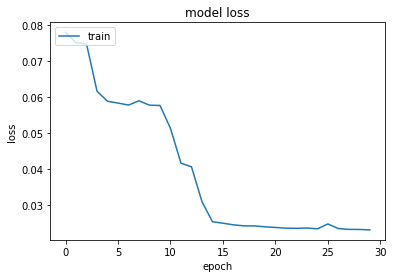

In [40]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Predicting for a sample image

In [41]:
def predict_fun(model,image_path,noise_level=30):
  #Creating patches for test image
  patches=extract_patches(image_path,40,[1])
  test_image=cv2.imread(image_path)
  test_image=cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
  patches=np.array(patches)
  ground_truth=join_patches(patches,test_image.shape)

  #predicting the output on the patches of test image
  patches = patches.astype('float32') /255.
  patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
  patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
  noisy_image=join_patches(patches_noisy,test_image.shape)

  denoised_patches=model.predict(patches_noisy)
  denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)

  #Creating entire denoised image from denoised patches
  denoised_image=join_patches(denoised_patches,test_image.shape)

  return patches_noisy,denoised_patches,ground_truth/255.,noisy_image,denoised_image


def plot_patches(patches_noisy,denoised_patches):
  fig, axs = plt.subplots(2,10,figsize=(20,4))
  for i in range(10):

    axs[0,i].imshow(patches_noisy[i])
    axs[0,i].title.set_text(' Noisy')
    axs[0,i].get_xaxis().set_visible(False)
    axs[0,i].get_yaxis().set_visible(False)

    axs[1,i].imshow(denoised_patches[i])
    axs[1,i].title.set_text('Denoised')
    axs[1,i].get_xaxis().set_visible(False)
    axs[1,i].get_yaxis().set_visible(False)
  plt.show()

def plot_predictions(ground_truth,noisy_image,denoised_image):
  fig, axs = plt.subplots(1,3,figsize=(15,15))
  axs[0].imshow(ground_truth)
  axs[0].title.set_text('Ground Truth')
  axs[1].imshow(noisy_image)  
  axs[1].title.set_text('Noisy Image')
  axs[2].imshow(denoised_image)
  axs[2].title.set_text('Denoised Image')
  plt.show()

3/3 [==============================] - 0s 15ms/step
PSNR of Noisy Image :  18.84634748326528
PSNR of Denoised Image :  27.109553583200807


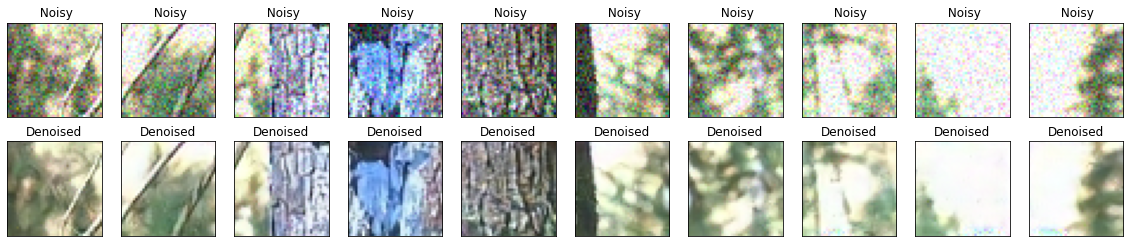

In [42]:
filepath='./images/test/100039.jpg'
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,filepath)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

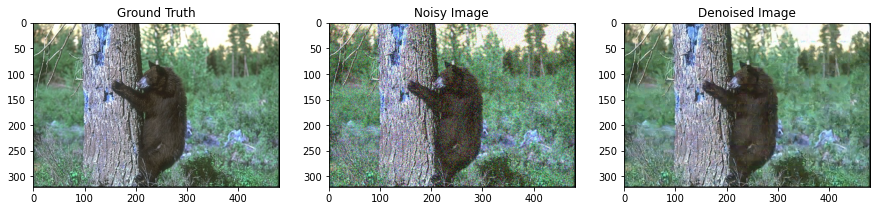

In [43]:
plot_predictions(ground_truth,noisy_image,denoised_image)